## **Monocular Based Dimension Estimation**

In [99]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def extract_orb_keypoints(gray_img, max_features=1000):
    """
    Detect and return keypoints from a gray image using ORB.
    """
    orb = cv2.ORB_create(nfeatures=max_features)
    kps = orb.detect(gray_img, None)
    kps = sorted(kps, key=lambda x: -x.response)[:max_features]
    return kps

def extract_sift_keypoints(gray_img, max_features=1000):
    """
    Detect and return keypoints from a gray image using SIFT.
    """
    sift = cv2.SIFT_create(nfeatures=max_features)
    kps = sift.detect(gray_img, None)
    kps = sorted(kps, key=lambda x: -x.response)[:max_features]
    return kps

def extract_gftt_keypoints(gray_img, max_features=1000):
    """
    Detect and return keypoints using GoodFeaturesToTrack (Shi-Tomasi corners).
    """
    corners = cv2.goodFeaturesToTrack(
        gray_img,
        maxCorners=max_features,
        qualityLevel=0.005,
        minDistance=10,
        blockSize=7,
    )
    
    # Convert corners to KeyPoint objects
    kps = []
    if corners is not None:
        corners = np.int32(corners)
        for corner in corners:
            x, y = corner.ravel()
            kp = cv2.KeyPoint(x=float(x), y=float(y), size=1)
            kps.append(kp)
    return kps

def track_features_bidirectional(prev_gray, curr_gray, prev_pts, 
                               lk_params=None, back_threshold=5.0):
    """
    Track features using bidirectional optical flow for better accuracy.
    """
    if lk_params is None:
        lk_params = dict(
            winSize=(21, 21),
            maxLevel=4,
            criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01),
            minEigThreshold=1e-4,
            flags=cv2.OPTFLOW_LK_GET_MIN_EIGENVALS
        )
    
    # Forward tracking
    curr_pts, status_fwd, err_fwd = cv2.calcOpticalFlowPyrLK(
        prev_gray, curr_gray, prev_pts, None, **lk_params
    )
    # Filter out points that weren't found in forward tracking
    curr_pts_valid = curr_pts[status_fwd.ravel() == 1]
    prev_pts_valid = prev_pts[status_fwd.ravel() == 1]
    
    # Backward tracking only on valid points
    prev_pts_back, status_back, err_back = cv2.calcOpticalFlowPyrLK(
        curr_gray, prev_gray, curr_pts_valid, None, **lk_params
    )
    
    # Calculate bidirectional error only for points tracked both ways
    back_error = np.linalg.norm(prev_pts_valid.reshape(-1, 2) - 
                               prev_pts_back.reshape(-1, 2), axis=1)
    
    # Find points that were successfully tracked in both directions
    good_pts = back_error < back_threshold
    
    # Only return points that passed both forward and backward tests
    good_curr = curr_pts_valid[good_pts]
    good_prev = prev_pts_valid[good_pts]

    if len(good_curr) > 0:
        # Calculate flow vectors
        flow_vectors = good_curr.reshape(-1, 2) - good_prev.reshape(-1, 2)
        
        # Get points in bottom half of image
        img_height = prev_gray.shape[0]
        bottom_mask = good_prev.reshape(-1, 2)[:, 1] > img_height/2
        bottom_flows = flow_vectors[bottom_mask]
        
        if len(bottom_flows) > 0:
            # Calculate dominant horizontal flow direction in bottom half
            bottom_dx = bottom_flows[:, 0]  # x component of flow
            mean_bottom_dx = np.mean(bottom_dx)
            
            # Determine dominant direction (-1 for left, 1 for right)
            dominant_direction = np.sign(mean_bottom_dx)
            
            # Filter points based on flow direction consistency
            flow_dx = flow_vectors[:, 0]  # x component of all flows
            direction_mask = np.sign(flow_dx) == dominant_direction
            
            # Update good points
            good_curr = good_curr[direction_mask]
            good_prev = good_prev[direction_mask]
            
    return good_curr, good_prev, None

def track_consecutive_frames(img1, img2, max_features=1000):
    """
    Track features between two consecutive frames using bidirectional optical flow.
    
    Args:
        img1: First image
        img2: Second image
        max_features: Maximum number of features to detect
    
    Returns:
        tracked_img: Image with tracked features and flow vectors
    """
    # Convert images to grayscale
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    # Detect keypoints in first frame
    keypoints = extract_gftt_keypoints(gray1, max_features)

    # Convert keypoints to numpy array of points
    prev_pts = np.array([kp.pt for kp in keypoints], dtype=np.float32).reshape(-1, 1, 2)
    
    # Track features
    if len(prev_pts) > 0:
        curr_pts, prev_pts, status = track_features_bidirectional(
            gray1, gray2, prev_pts,
            back_threshold=3.0  # Increased threshold for more matches
        )
        
        # Visualize the tracking on grayscale image
        vis_frame = cv2.cvtColor(gray2, cv2.COLOR_GRAY2BGR)  # Convert to BGR for colored visualization
        
        # Draw tracks
        for (curr, prev) in zip(curr_pts, prev_pts):
            x1, y1 = curr.ravel()
            x2, y2 = prev.ravel()
            # Draw flow arrow
            cv2.arrowedLine(vis_frame, 
                          (int(x2), int(y2)), 
                          (int(x1), int(y1)),
                          (0, 255, 0), 1,  # Green arrows
                          tipLength=0.2)
            # Draw points
            cv2.circle(vis_frame, (int(x1), int(y1)), 1, (0, 255, 0), -1)  # Green current points
            #cv2.circle(vis_frame, (int(x2), int(y2)), 3, (255, 0, 0), -1)  # Blue previous points
            
        return vis_frame, curr_pts, prev_pts
    
    return img2, None, None

def draw_keypoints(gray_img, keypoints, color=(0, 255, 0), radius=3):
    """
    Draw keypoints onto the gray image (converted to BGR) using the given color.
    Returns a BGR image with green keypoints by default.
    """
    out = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2BGR)
    for kp in keypoints:
        x, y = int(round(kp.pt[0])), int(round(kp.pt[1]))
        cv2.circle(out, (x, y), radius, color, thickness=-1, lineType=cv2.LINE_AA)
    return out

(np.float64(-0.5), np.float64(463.5), np.float64(831.5), np.float64(-0.5))

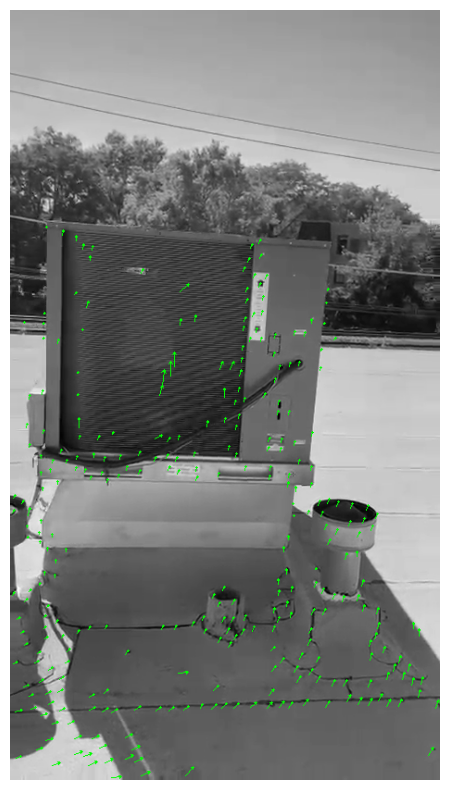

In [100]:
img_path = 'images/rtu1/0004.png'
img2_path = 'images/rtu1/0005.png'
img = cv2.imread(img_path)
img2 = cv2.imread(img2_path)

#img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#kps = extract_gftt_keypoints(img_gray)
#prev_pts = np.array([kp.pt for kp in kps], dtype=np.float32).reshape(-1, 1, 2)

#featured_img = draw_keypoints(img_gray, kps, color=(0, 255, 0), radius=1)

# Example usage with your existing image paths
img1 = cv2.imread(img_path)
img2 = cv2.imread(img2_path)

# Track features between consecutive frames
tracked_img, curr_pts, prev_pts = track_consecutive_frames(img1, img2, max_features=1000)


#combined = np.hstack((img_rgb, featured_img))

plt.figure(figsize=(20, 10))
plt.imshow(tracked_img)
plt.axis('off')

## **Process video**

In [101]:
def process_video(video_path, feature_type='gftt', max_features=1000, target_fps=10):
    """
    Process video and save frames with detected features.
    
    Args:
        video_path: Path to input video
        feature_type: Type of feature detector ('gftt', 'sift', or 'orb')
        max_features: Maximum number of features to detect
        target_fps: Desired output frames per second (default: 10)
    """
    # Create output directory based on video name
    video_name = os.path.splitext(os.path.basename(video_path))[0]
    output_dir = f'outputs/{video_name}'
    os.makedirs(output_dir, exist_ok=True)
    
    # Select feature detector
    if feature_type == 'gftt':
        detector = extract_gftt_keypoints
    elif feature_type == 'sift':
        detector = extract_sift_keypoints
    else:
        detector = extract_orb_keypoints
    
    # Open video
    cap = cv2.VideoCapture(video_path)
    
    # Get video properties
    original_fps = cap.get(cv2.CAP_PROP_FPS)
    frame_step = int(round(original_fps / target_fps))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f'Original FPS: {original_fps}')
    print(f'Target FPS: {target_fps}')
    print(f'Processing every {frame_step} frames')
    
    frame_count = 0
    saved_count = 0
    
    # Read first frame
    ret, prev_frame = cap.read()
    if not ret:
        print("Failed to read video")
        return
    
    while cap.isOpened():
        ret, curr_frame = cap.read()
        if not ret:
            break
            
        if frame_count % frame_step == 0:
            # Track features between consecutive frames
            tracked_frame, curr_pts, prev_pts = track_consecutive_frames(
                prev_frame, curr_frame, max_features
            )
            
            # Save tracked frame
            output_path = os.path.join(output_dir, f'{saved_count:04d}.png')
            cv2.imwrite(output_path, tracked_frame)
            
            if saved_count % 10 == 0:
                print(f'Processed {saved_count} frames')
                if curr_pts is not None:
                    print(f'Tracked {len(curr_pts)} features')
            
            saved_count += 1
            prev_frame = curr_frame.copy()
        
        frame_count += 1
    
    cap.release()
    print(f'Finished processing {saved_count} frames')
    print(f'Output saved to {output_dir}/')

# Example usage
video_path = 'videos/rtu1.mp4'
process_video(video_path, feature_type='gftt', max_features=1000, target_fps=10)

Original FPS: 59.94323557237465
Target FPS: 10
Processing every 6 frames
Processed 0 frames
Tracked 311 features
Processed 10 frames
Tracked 272 features
Processed 20 frames
Tracked 332 features
Processed 30 frames
Tracked 458 features
Processed 40 frames
Tracked 363 features
Processed 50 frames
Tracked 377 features
Processed 60 frames
Tracked 322 features
Processed 70 frames
Tracked 358 features
Processed 80 frames
Tracked 302 features
Processed 90 frames
Tracked 166 features
Processed 100 frames
Tracked 211 features
Processed 110 frames
Tracked 326 features
Processed 120 frames
Tracked 392 features
Processed 130 frames
Tracked 456 features
Processed 140 frames
Tracked 378 features
Processed 150 frames
Tracked 396 features
Processed 160 frames
Tracked 421 features
Processed 170 frames
Tracked 393 features
Finished processing 176 frames
Output saved to outputs/rtu1/


In [6]:
import numpy as np
import plotly.graph_objects as go
import json

def read_arcore_pointcloud(bin_file_path):
    """
    Read ARCore point cloud from binary file.
    
    Args:
        bin_file_path: Path to the .bin file
    
    Returns:
        points: Nx3 array of (x, y, z) coordinates
        confidence: N array of confidence scores
    """
    # Read binary data as float32, little-endian
    data = np.fromfile(bin_file_path, dtype=np.float32)
    
    # Reshape into points (each point has 4 floats: x, y, z, confidence)
    num_points = len(data) // 4
    data = data[:num_points * 4].reshape(-1, 4)
    
    # Extract coordinates and confidence
    points = data[:, :3]  # x, y, z
    confidence = data[:, 3]  # confidence score
    
    return points, confidence

def read_arcore_planes(json_file_path):
    """
    Read ARCore detected planes from JSON file.
    
    Args:
        json_file_path: Path to the .json file
    
    Returns:
        planes: List of plane dictionaries
    """
    with open(json_file_path, 'r') as f:
        planes = json.load(f)
    return planes

def quaternion_to_rotation_matrix(q):
    """
    Convert quaternion to rotation matrix.
    
    Args:
        q: Quaternion [w, x, y, z]
    
    Returns:
        R: 3x3 rotation matrix
    """
    w, x, y, z = q
    R = np.array([
        [1 - 2*y*y - 2*z*z, 2*x*y - 2*z*w, 2*x*z + 2*y*w],
        [2*x*y + 2*z*w, 1 - 2*x*x - 2*z*z, 2*y*z - 2*x*w],
        [2*x*z - 2*y*w, 2*y*z + 2*x*w, 1 - 2*x*x - 2*y*y]
    ])
    return R

def create_plane_mesh(plane, color='lightblue'):
    """
    Create a 3D mesh for a plane.
    
    Args:
        plane: Plane dictionary from JSON
        color: Color for the mesh
    
    Returns:
        mesh: Plotly Mesh3d trace
    """
    extent_x = plane['extentX']
    extent_z = plane['extentZ']
    center_pose = plane['centerPose']
    
    # Extract translation and quaternion
    tx, ty, tz, qw, qx, qy, qz = center_pose
    
    # Rotation matrix
    R = quaternion_to_rotation_matrix([qw, qx, qy, qz])
    
    # Define local vertices of the rectangle (centered at origin)
    half_x = extent_x / 2
    half_z = extent_z / 2
    local_vertices = np.array([
        [-half_x, 0, -half_z],
        [half_x, 0, -half_z],
        [half_x, 0, half_z],
        [-half_x, 0, half_z]
    ])
    
    # Transform vertices
    transformed_vertices = (R @ local_vertices.T).T + np.array([tx, ty, tz])
    
    # Define faces (two triangles for the rectangle)
    i = [0, 1, 2, 0, 2, 3]
    j = [1, 2, 3, 2, 3, 0]
    k = [2, 3, 0, 3, 0, 1]
    
    mesh = go.Mesh3d(
        x=transformed_vertices[:, 0],
        y=transformed_vertices[:, 1],
        z=transformed_vertices[:, 2],
        i=i, j=j, k=k,
        color=color,
        opacity=0.5,
        name=f"Plane ({plane['type']})"
    )
    
    return mesh

def plot_pointcloud_interactive(points, confidence=None, planes=None, title="ARCore Point Cloud"):
    """
    Plot 3D point cloud interactively using Plotly with origin, axes, and planes.
    
    Args:
        points: Nx3 array of (x, y, z) coordinates
        confidence: Optional N array of confidence scores for coloring
        planes: Optional list of plane dictionaries
        title: Plot title
    """
    # Create the scatter plot for points
    if confidence is not None:
        marker = dict(
            size=2,
            color=confidence,
            colorscale='Viridis',
            showscale=True,
            colorbar=dict(title="Confidence")
        )
    else:
        marker = dict(
            size=2,
            color='blue',
            showscale=False
        )
    
    point_trace = go.Scatter3d(
        x=points[:, 0],
        y=points[:, 1],
        z=points[:, 2],
        mode='markers',
        marker=marker,
        hovertemplate='X: %{x:.3f}<br>Y: %{y:.3f}<br>Z: %{z:.3f}<extra></extra>',
        name='Point Cloud'
    )
    
    # Define axis lengths based on point cloud bounds
    max_range = max(
        points[:, 0].max() - points[:, 0].min(),
        points[:, 1].max() - points[:, 1].min(),
        points[:, 2].max() - points[:, 2].min()
    ) / 4  # Use 1/4 of the range for axis length
    
    # X-axis (red)
    x_axis = go.Scatter3d(
        x=[0, max_range, None, 0, 0, None, 0, 0],
        y=[0, 0, None, 0, 0, None, 0, 0],
        z=[0, 0, None, 0, 0, None, 0, 0],
        mode='lines',
        line=dict(color='red', width=5),
        hoverinfo='skip',
        name='X-axis'
    )
    
    # Y-axis (green)
    y_axis = go.Scatter3d(
        x=[0, 0, None, 0, 0, None, 0, 0],
        y=[0, max_range, None, 0, 0, None, 0, 0],
        z=[0, 0, None, 0, 0, None, 0, 0],
        mode='lines',
        line=dict(color='green', width=5),
        hoverinfo='skip',
        name='Y-axis'
    )
    
    # Z-axis (blue)
    z_axis = go.Scatter3d(
        x=[0, 0, None, 0, 0, None, 0, 0],
        y=[0, 0, None, 0, 0, None, 0, 0],
        z=[0, max_range, None, 0, 0, None, 0, 0],
        mode='lines',
        line=dict(color='blue', width=5),
        hoverinfo='skip',
        name='Z-axis'
    )
    
    # Origin marker
    origin = go.Scatter3d(
        x=[0],
        y=[0],
        z=[0],
        mode='markers',
        marker=dict(size=8, color='black'),
        hovertemplate='Origin<br>X: 0.000<br>Y: 0.000<br>Z: 0.000',
        name='Origin'
    )
    
    # Combine traces
    traces = [point_trace, x_axis, y_axis, z_axis, origin]
    
    # Add plane meshes if provided
    if planes:
        for plane in planes:
            if plane['type'] == 'VERTICAL':
                color = 'lightgreen'
            else:  # HORIZONTAL
                color = 'lightblue'
            mesh = create_plane_mesh(plane, color)
            traces.append(mesh)
    
    # Create figure
    fig = go.Figure(data=traces)
    
    # Update layout
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title='X (m)',
            yaxis_title='Y (m)',
            zaxis_title='Z (m)',
            aspectmode='data'
        ),
        margin=dict(l=0, r=0, b=0, t=40)
    )
    
    # Show the interactive plot
    fig.show()

# Example usage - replace with your actual file paths
bin_file_path = './accumulated_pointcloud.bin'  # Update this path
json_file_path = './detected_planes.json'  # Update this path

# Read the point cloud
points, confidence = read_arcore_pointcloud(bin_file_path)

# Read the planes
planes = read_arcore_planes(json_file_path)

print(f"Loaded {len(points)} points")
print(f"Loaded {len(planes)} planes")
print(f"Point cloud bounds:")
print(f"X: {points[:, 0].min():.3f} to {points[:, 0].max():.3f}")
print(f"Y: {points[:, 1].min():.3f} to {points[:, 1].max():.3f}")
print(f"Z: {points[:, 2].min():.3f} to {points[:, 2].max():.3f}")

# Plot the point cloud and planes interactively
plot_pointcloud_interactive(points, confidence, planes)

Loaded 47 points
Loaded 3 planes
Point cloud bounds:
X: -0.062 to -0.000
Y: -0.221 to 0.029
Z: -0.240 to -0.132


In [ ]:
import numpy as np
import plotly.graph_objects as go
import json

# Assuming the functions are already defined in previous cells

# Filter horizontal planes and find the closest to the point cloud centroid
def select_best_horizontal_plane(points, planes):
    # Filter horizontal planes
    horizontal_planes = [p for p in planes if 'HORIZONTAL' in p['type']]
    
    if not horizontal_planes:
        return None
    
    # Compute point cloud centroid
    centroid = np.mean(points, axis=0)
    
    # Find closest plane by distance to centroid
    min_dist = float('inf')
    best_plane = None
    for plane in horizontal_planes:
        plane_center = np.array(plane['centerPose'][:3])
        dist = np.linalg.norm(centroid - plane_center)
        if dist < min_dist:
            min_dist = dist
            best_plane = plane
    
    return best_plane

# Project points onto the plane and keep original heights
def project_points_to_plane(points, plane):
    tx, ty, tz, qw, qx, qy, qz = plane['centerPose']
    # For horizontal planes, normal is always [0, 1, 0] (upwards)
    normal = np.array([0, 1, 0])
    point_on_plane = np.array([tx, ty, tz])
    
    # Project each point and keep original Y
    projected = []
    heights = []
    for p in points:
        vec = p - point_on_plane
        dist = np.dot(vec, normal)
        proj = p - dist * normal
        projected.append(proj)
        heights.append(p[1])  # Original Y
    return np.array(projected), np.array(heights)

# Get 2D coordinates on the plane
def get_2d_coords(projected_points, plane):
    tx, ty, tz, qw, qx, qy, qz = plane['centerPose']
    R = quaternion_to_rotation_matrix([qw, qx, qy, qz])
    local_x = R @ np.array([1, 0, 0])
    local_z = R @ np.array([0, 0, 1])
    point_on_plane = np.array([tx, ty, tz])
    
    u = []
    v = []
    for p in projected_points:
        vec = p - point_on_plane
        u.append(np.dot(vec, local_x))
        v.append(np.dot(vec, local_z))
    return np.array(u), np.array(v)

# Fit oriented bounding box using PCA
def fit_oriented_bbox(u, v):
    points_2d = np.column_stack((u, v))
    # Compute covariance
    cov = np.cov(points_2d.T)
    eigvals, eigvecs = np.linalg.eig(cov)
    # Sort by eigenvalue
    idx = np.argsort(eigvals)[::-1]
    eigvecs = eigvecs[:, idx]
    # Rotate points
    rotated = points_2d @ eigvecs
    min_vals = np.min(rotated, axis=0)
    max_vals = np.max(rotated, axis=0)
    # Corners in rotated frame
    corners_rot = np.array([
        [min_vals[0], min_vals[1]],
        [max_vals[0], min_vals[1]],
        [max_vals[0], max_vals[1]],
        [min_vals[0], max_vals[1]]
    ])
    # Rotate back
    corners_2d = corners_rot @ eigvecs.T
    return corners_2d

# Transform 2D corners back to 3D
def corners_2d_to_3d(corners_2d, plane):
    tx, ty, tz, qw, qx, qy, qz = plane['centerPose']
    R = quaternion_to_rotation_matrix([qw, qx, qy, qz])
    local_x = R @ np.array([1, 0, 0])
    local_z = R @ np.array([0, 0, 1])
    point_on_plane = np.array([tx, ty, tz])
    
    corners_3d = []
    for c in corners_2d:
        pos = point_on_plane + c[0] * local_x + c[1] * local_z
        corners_3d.append(pos)
    return np.array(corners_3d)

# Check if 2D point is inside bbox
def point_in_bbox(u, v, corners_2d):
    # Simple polygon check, assume rectangle
    min_u = np.min(corners_2d[:, 0])
    max_u = np.max(corners_2d[:, 0])
    min_v = np.min(corners_2d[:, 1])
    max_v = np.max(corners_2d[:, 1])
    return (u >= min_u) & (u <= max_u) & (v >= min_v) & (v <= max_v)

# Create 3D bbox traces
def create_3d_bbox_traces(bbox_corners_bottom, farthest_height, plane):
    tx, ty, tz, qw, qx, qy, qz = plane['centerPose']
    # Determine direction based on farthest height
    if farthest_height > ty:
        normal = np.array([0, 1, 0])  # Up
    else:
        normal = np.array([0, -1, 0])  # Down
    
    # Top corners
    bbox_corners_top = bbox_corners_bottom + (farthest_height - ty) * normal
    
    # Bottom rectangle
    bottom_x = list(bbox_corners_bottom[:, 0]) + [bbox_corners_bottom[0, 0]]
    bottom_y = list(bbox_corners_bottom[:, 1]) + [bbox_corners_bottom[0, 1]]
    bottom_z = list(bbox_corners_bottom[:, 2]) + [bbox_corners_bottom[0, 2]]
    
    bottom_trace = go.Scatter3d(
        x=bottom_x, y=bottom_y, z=bottom_z,
        mode='lines', line=dict(color='red', width=5),
        name='Bottom of BBox'
    )
    
    # Top rectangle
    top_x = list(bbox_corners_top[:, 0]) + [bbox_corners_top[0, 0]]
    top_y = list(bbox_corners_top[:, 1]) + [bbox_corners_top[0, 1]]
    top_z = list(bbox_corners_top[:, 2]) + [bbox_corners_top[0, 2]]
    
    top_trace = go.Scatter3d(
        x=top_x, y=top_y, z=top_z,
        mode='lines', line=dict(color='red', width=5),
        name='Top of BBox'
    )
    
    # Vertical lines connecting bottom to top
    vertical_traces = []
    for i in range(4):
        vert_trace = go.Scatter3d(
            x=[bbox_corners_bottom[i, 0], bbox_corners_top[i, 0]],
            y=[bbox_corners_bottom[i, 1], bbox_corners_top[i, 1]],
            z=[bbox_corners_bottom[i, 2], bbox_corners_top[i, 2]],
            mode='lines', line=dict(color='red', width=5),
            showlegend=False
        )
        vertical_traces.append(vert_trace)
    
    return [bottom_trace, top_trace] + vertical_traces

# Plot with 3D bbox
def plot_with_3d_bbox(points, confidence, plane, bbox_traces):
    # Point trace
    if confidence is not None:
        marker = dict(size=2, color=confidence, colorscale='Viridis', showscale=True, colorbar=dict(title="Confidence"))
    else:
        marker = dict(size=2, color='blue', showscale=False)
    
    point_trace = go.Scatter3d(
        x=points[:, 0], y=points[:, 1], z=points[:, 2],
        mode='markers', marker=marker,
        hovertemplate='X: %{x:.3f}<br>Y: %{y:.3f}<br>Z: %{z:.3f}<extra></extra>',
        name='Point Cloud'
    )
    
    # Plane mesh
    mesh = create_plane_mesh(plane, 'lightblue')
    
    # Axes and origin
    max_range = max(
        points[:, 0].max() - points[:, 0].min(),
        points[:, 1].max() - points[:, 1].min(),
        points[:, 2].max() - points[:, 2].min()
    ) / 4
    
    x_axis = go.Scatter3d(x=[0, max_range], y=[0, 0], z=[0, 0], mode='lines', line=dict(color='red', width=5), name='X-axis')
    y_axis = go.Scatter3d(x=[0, 0], y=[0, max_range], z=[0, 0], mode='lines', line=dict(color='green', width=5), name='Y-axis')
    z_axis = go.Scatter3d(x=[0, 0], y=[0, 0], z=[0, max_range], mode='lines', line=dict(color='blue', width=5), name='Z-axis')
    origin = go.Scatter3d(x=[0], y=[0], z=[0], mode='markers', marker=dict(size=8, color='black'), name='Origin')
    
    fig = go.Figure(data=[point_trace, mesh] + bbox_traces + [x_axis, y_axis, z_axis, origin])
    fig.update_layout(
        title="Point Cloud with Plane and 3D Bounding Box",
        scene=dict(xaxis_title='X (m)', yaxis_title='Y (m)', zaxis_title='Z (m)', aspectmode='data'),
        margin=dict(l=0, r=0, b=0, t=40)
    )
    fig.show()

# Load data
bin_file_path = './accumulated_pointcloud.bin'
json_file_path = './detected_planes.json'
points, confidence = read_arcore_pointcloud(bin_file_path)
planes = read_arcore_planes(json_file_path)

# Select best plane
best_plane = select_best_horizontal_plane(points, planes)
if best_plane is None:
    print("No horizontal planes found.")
else:
    print(f"Selected plane: {best_plane['type']}")
    
    # Project points and get heights
    projected, heights = project_points_to_plane(points, best_plane)
    
    # Get 2D coords
    u, v = get_2d_coords(projected, best_plane)
    
    # Fit bbox
    corners_2d = fit_oriented_bbox(u, v)
    
    # To 3D bottom corners
    bbox_corners_bottom = corners_2d_to_3d(corners_2d, best_plane)
    
    # Find farthest height for points inside bbox
    inside = point_in_bbox(u, v, corners_2d)
    if np.any(inside):
        heights_inside = heights[inside]
        distances = np.abs(heights_inside - best_plane['centerPose'][1])
        farthest_idx = np.argmax(distances)
        farthest_height = heights_inside[farthest_idx]
    else:
        farthest_height = best_plane['centerPose'][1]  # Default to plane height
    
    print(f"Farthest height: {farthest_height:.3f}")
    
    # Create 3D bbox traces
    bbox_traces = create_3d_bbox_traces(bbox_corners_bottom, farthest_height, best_plane)
    
    # Plot
    plot_with_3d_bbox(points, confidence, best_plane, bbox_traces)

Selected plane: HORIZONTAL_UPWARD_FACING
Farthest height: 0.029
